In [2]:
import sys
sys.path.append("../")

from hybri import Hybrizone, HybriParams, PolarPoint, AirData, AngleMode, CoordMode, BuildMode, CurveMode, InterpolationDomain
import librosa as lb
import numpy as np
import time
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize


In [2]:
# main scripts
HRIR_PATH = "/Users/pm/AcaHub/Coding/BinauralSpatial/data/HRIR-KEMAR_DATASET.h5"
RIR_PATH = "/Users/pm/AcaHub/Coding/BinauralSpatial/data/RIR-MIT_SURVEY.h5"
AUDIO_PATH = "/Users/pm/AcaHub/AudioSamples/suzanne_mono.wav"

CHUNK = 2048
SR = 44100
CHANNELS = 2

PARAMS = HybriParams(
        hrir_database_path=HRIR_PATH, 
        rir_database_path=RIR_PATH, 
        coord_mode=CoordMode.REGULAR, # TODO: interaural problema itd a 90 e 270 gradi
        interp_domain=InterpolationDomain.FREQUENCY,
        build_mode=BuildMode.SPHERICAL,
        chunk_size=CHUNK,
        interpolation_neighs=2
)

In [3]:

# start hybri
AURALIZER = Hybrizone(params=PARAMS)

# set air conditions
air_conditions = AirData(temperature=20, humidity=50, pressure=101325.0)
AURALIZER.imposed_air_conditions(air_data=air_conditions)

i1 = 10
i2 = 100

AURALIZER.set_rirs(rir1=i1, rir2=i2, smooth_factor=0.1)

current_phi = 0
current_theta = 0
current_rho = 0
dstep = 0.1

hrirs = []
itds = []
distances = [1.7, 5, 10, 25, 30, 100]
# distances = [1.7, 5, 10, 20, 30, 50]
# distances = [1.7, 5, 10]
# distances = [0.01, 0.05, 0.1, 0.25, 0.5, 1.7]
gains = []
rirs = []

temperatures = [0, 5, 10, 20, 50, 70]
humidity = [5, 10, 25, 50, 75, 90]
# for t in temperatures:
#     air_conditions = AirData(temperature=t, humidity=50, pressure=101325.0)
#     AURALIZER.imposed_air_conditions(air_data=air_conditions)
#     gains.append(AURALIZER.hrir_builder.db_attenuation)
# for d in distances:
#     current_theta = 0
#     hrirs_temp = []
#     itds_temp = []
# while True:
#     pos = PolarPoint(rho=1.7, phi=0.0, theta=current_theta, opt=AngleMode.DEGREE) 
#     AURALIZER.set_position(position=pos)

#     if current_theta >= 360: 
#         break

#     # generates kernels (HRIR and RIR)
#     kernels = AURALIZER.get_kernels()
#     if kernels is not None:
#         # hrirs_temp.append(kernels.hrir)
#         hrirs.append(kernels.hrir)
#         # itds.append(kernels.itd)
#         # itds_temp.append(kernels.itd)
#         # gains.append(kernels.gain)
#         current_theta += dstep

    # time.sleep(1 / SR)

# itds.append(itds_temp)
# hrirs.append(hrirs_temp)
# gains = np.array(gains)


pos = PolarPoint(rho=1.7, phi=0.0, theta=0.0, opt=AngleMode.DEGREE) 
AURALIZER.set_position(position=pos)
AURALIZER.set_morph_data(direction=0.37, morph_curve=CurveMode.SIGMOID)
# generates kernels (HRIR and RIR)
kernels = AURALIZER.get_kernels()


# AURALIZER.close()


(6, 3600)


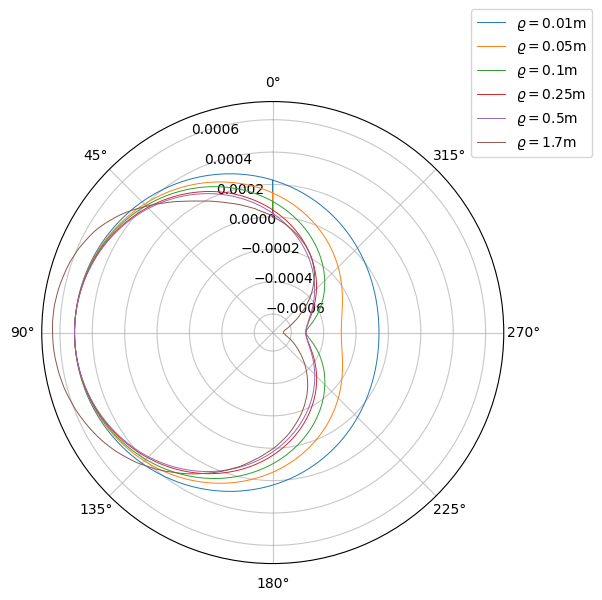

(6, 3600)

In [4]:
degree = np.linspace(0, 360, num=len(itds[0]))
degree = np.radians(degree)
itds = np.array(itds)
print(itds.shape)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, polar=True)
 
# ax.plot(degree, itds[0], c="r", lw=0.7, label=r"$\varrho = 0.001$m")
ax.plot(degree, itds[0], lw=0.7, label=r"$\varrho = 0.01$m")
ax.plot(degree, itds[1], lw=0.7, label=r"$\varrho = 0.05$m")
ax.plot(degree, itds[2], lw=0.7, label=r"$\varrho = 0.1$m")
ax.plot(degree, itds[3], lw=0.7, label=r"$\varrho = 0.25$m")
ax.plot(degree, itds[4], lw=0.7, label=r"$\varrho = 0.5$m")
ax.plot(degree, itds[5], lw=0.7, label=r"$\varrho = 1.7$m")

ax.set_theta_direction(1)  # senso orario
ax.set_theta_zero_location('N')  # 0° in alto
ax.grid(alpha=0.7)
ax.legend(loc='upper left', bbox_to_anchor=(0.93, 1.2), borderaxespad=0.)

 
plt.show()
itds.shape

(4410, 3600)


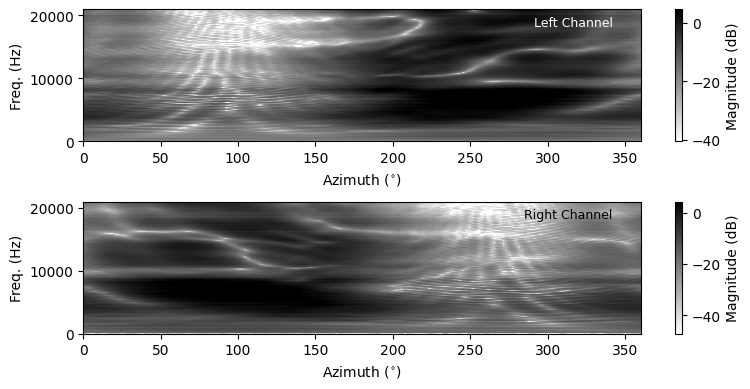

In [19]:
h = np.array(hrirs, dtype=np.float64)
left = h[:, :, 0].T
right = h[:, :, 1].T
print(left.shape)

lfft = np.fft.rfft(left, axis=0)
rfft = np.fft.rfft(right, axis=0)
lmag = lb.amplitude_to_db(np.abs(lfft))
rmag = lb.amplitude_to_db(np.abs(rfft))

langle = np.angle(lfft)
rangle = np.angle(rfft)

tt = np.linspace(0, 360, num=left.shape[1])
ff = np.fft.rfftfreq(n=left.shape[0], d=1 / SR)

fig, ax = plt.subplots(2, 1, figsize=(8, 4))

limit = 2100
norml = Normalize(vmin=np.percentile(lmag, 3), vmax=np.percentile(lmag, 97))
normr = Normalize(vmin=np.percentile(rmag, 3), vmax=np.percentile(rmag, 97))
m = ax[0].pcolormesh(tt, ff[:limit], lmag[:limit, :], cmap="gray_r", norm=norml)
ax[0].set_xlabel(r"Azimuth ($^{\circ}$)")
ax[0].set_ylabel("Freq. (Hz)")
ax[0].text(0.95, 0.95, "Left Channel", fontsize=9, ha='right', va='top', color='white', transform=ax[0].transAxes)
mm = ax[1].pcolormesh(tt, ff[:limit], rmag[:limit, :], cmap="gray_r", norm=normr)
ax[1].set_xlabel(r"Azimuth ($^{\circ}$)")
ax[1].set_ylabel("Freq. (Hz)")
ax[1].text(0.95, 0.95, "Right Channel", fontsize=9, ha='right', va='top', color='black', transform=ax[1].transAxes)
fig.colorbar(m, ax=ax[0], label="Magnitude (dB)")
fig.colorbar(mm, ax=ax[1], label="Magnitude (dB)")
plt.tight_layout()
plt.show()

In [20]:
h = np.array(hrirs)
# mag_ref = np.abs(np.fft.rfft(h[0], axis=-2))
lmag = np.abs(lfft)
rmag = np.abs(rfft)
ref_dist = 20 * np.log10(((rmag + 1e-12) / (lmag + 1e-12)) + 1e-12)
# ild = []
# ild_static = []
# for index in range(h.shape[0]):
#     mag_fft = np.abs(np.fft.rfft(h[index], axis=-2))
#     ild_temp = []
#     for angle_index in range(mag_fft.shape[0]):
#         ld = 20 * np.log10((mag_fft[angle_index, :, 1] + 1e-12) / (mag_fft[angle_index, :, 0] + 1e-12))
#         ild_temp.append(ld - ref_dist[angle_index])
#     ild.append(ild_temp)
# ild = np.array(ild)
# ild_static = np.array(ref_dist)
# avg_ild = np.mean(ild, axis=1)
# std_ild = np.std(ild, axis=1)
# avg_ild.shape, ild_static.shape
# ild_static.shape


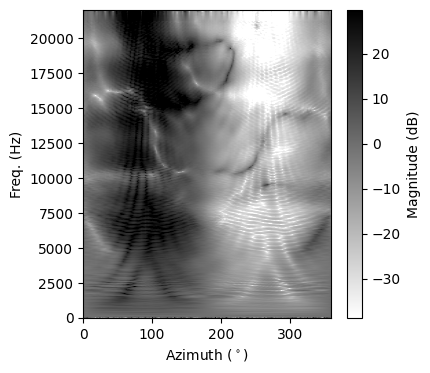

In [21]:
norm = Normalize(vmin=np.percentile(ref_dist, 3), vmax=np.percentile(ref_dist, 97))
plt.figure(figsize=(4, 4))
tt = np.linspace(0, 360, num=3600)
ff = np.fft.rfftfreq(n=4410, d=1 / SR)
plt.pcolormesh(tt, ff, ref_dist, cmap="gray_r", norm=norm)
plt.xlabel(r"Azimuth ($^\circ$)")
plt.ylabel("Freq. (Hz)")
plt.colorbar(label="Magnitude (dB)")
plt.show()

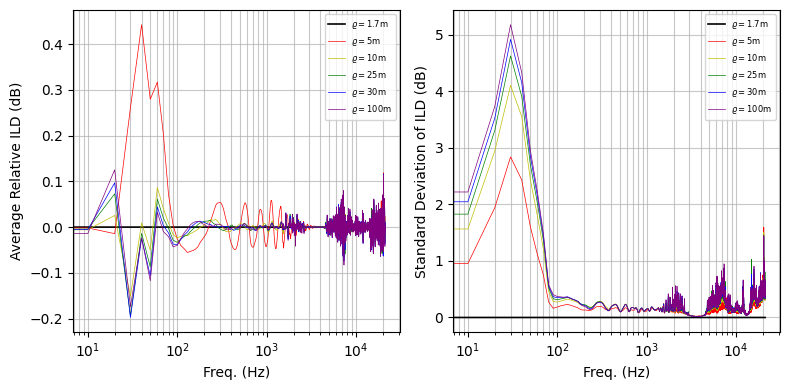

In [113]:
tt = np.linspace(0, 360, num=3600)
ff = np.fft.rfftfreq(n=4410, d=1 / SR)

colors = ["k", "r", "y", "g", "b", "purple"]


limit = 2110

fig, ax = plt.subplots(1, 2, figsize=(8, 4))


ax[0].semilogx(ff[:limit], avg_ild[0, :limit].T, c=colors[0], lw=1.2, label=r"$\varrho=$" f"{distances[0]}" r"$\mathrm{m}$")
ax[0].semilogx(ff[:limit], avg_ild[1, :limit].T, c=colors[1], lw=0.5, label=r"$\varrho=$" f"{distances[1]}" r"$\mathrm{m}$")
ax[0].semilogx(ff[:limit], avg_ild[2, :limit].T, c=colors[2], lw=0.5, label=r"$\varrho=$" f"{distances[2]}" r"$\mathrm{m}$")
ax[0].semilogx(ff[:limit], avg_ild[3, :limit].T, c=colors[3], lw=0.5, label=r"$\varrho=$" f"{distances[3]}" r"$\mathrm{m}$")
ax[0].semilogx(ff[:limit], avg_ild[4, :limit].T, c=colors[4], lw=0.5, label=r"$\varrho=$" f"{distances[4]}" r"$\mathrm{m}$")
ax[0].semilogx(ff[:limit], avg_ild[5, :limit].T, c=colors[5], lw=0.5, label=r"$\varrho=$" f"{distances[5]}" r"$\mathrm{m}$")
ax[0].set_xlabel("Freq. (Hz)")
ax[0].set_ylabel("Average Relative ILD (dB)")
ax[0].grid(True, which="both", alpha=0.7)
ax[0].legend(fontsize=6)
ax[1].semilogx(ff[:limit], std_ild[0, :limit].T, c=colors[0], lw=1.2, label=r"$\varrho=$" f"{distances[0]}" r"$\mathrm{m}$")
ax[1].semilogx(ff[:limit], std_ild[1, :limit].T, c=colors[1], lw=0.5, label=r"$\varrho=$" f"{distances[1]}" r"$\mathrm{m}$")
ax[1].semilogx(ff[:limit], std_ild[2, :limit].T, c=colors[2], lw=0.5, label=r"$\varrho=$" f"{distances[2]}" r"$\mathrm{m}$")
ax[1].semilogx(ff[:limit], std_ild[3, :limit].T, c=colors[3], lw=0.5, label=r"$\varrho=$" f"{distances[3]}" r"$\mathrm{m}$")
ax[1].semilogx(ff[:limit], std_ild[4, :limit].T, c=colors[4], lw=0.5, label=r"$\varrho=$" f"{distances[4]}" r"$\mathrm{m}$")
ax[1].semilogx(ff[:limit], std_ild[5, :limit].T, c=colors[5], lw=0.5, label=r"$\varrho=$" f"{distances[5]}" r"$\mathrm{m}$")
ax[1].set_xlabel("Freq. (Hz)")
ax[1].set_ylabel("Standard Deviation of ILD (dB)")
ax[1].grid(True, which="both", alpha=0.7)
ax[1].legend(fontsize=6)
plt.tight_layout()
plt.show()

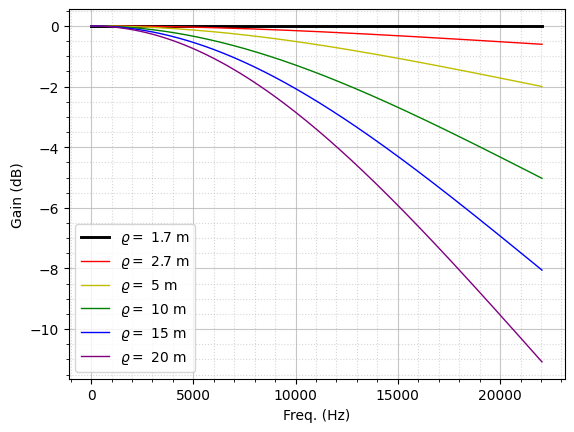

In [48]:
colors = ["k", "r", "y", "g", "b", "purple"]
f = np.linspace(0, 22050, num=gains.shape[1])
# plt.plot(f, -gains[0], lw=1, c=colors[0], label=r'$\mathrm{T} =$ 'f'{temperatures[0]}' r'$\mathrm{^\circ C}$')
# plt.plot(f, -gains[1], lw=1, c=colors[1], label=r'$\mathrm{T} =$ 'f'{temperatures[1]}' r'$\mathrm{^\circ C}$')
# plt.plot(f, -gains[2], lw=1, c=colors[2], label=r'$\mathrm{T} =$ 'f'{temperatures[2]}' r'$\mathrm{^\circ C}$')
# plt.plot(f, -gains[3], lw=2.1, c=colors[3], label=r'$\mathrm{T} =$ 'f'{temperatures[3]}' r'$\mathrm{^\circ C}$')
# plt.plot(f, -gains[4], lw=1, c=colors[4], label=r'$\mathrm{T} =$ 'f'{temperatures[4]}' r'$\mathrm{^\circ C}$')
# plt.plot(f, -gains[5], lw=1, c=colors[5], label=r'$\mathrm{T} =$ 'f'{temperatures[5]}' r'$\mathrm{^\circ C}$')
# plt.plot(f, -gains[0], lw=1, c=colors[0], label=r'$\mathrm{RH} = $' f'{humidity[0]}%')
# plt.plot(f, -gains[1], lw=1, c=colors[1], label=r'$\mathrm{RH} = $' f'{humidity[1]}%')
# plt.plot(f, -gains[2], lw=1, c=colors[2], label=r'$\mathrm{RH} = $' f'{humidity[2]}%')
# plt.plot(f, -gains[3], lw=2.1, c=colors[3], label=r'$\mathrm{RH} = $' f'{humidity[3]}%')
# plt.plot(f, -gains[4], lw=1, c=colors[4], label=r'$\mathrm{RH} = $' f'{humidity[4]}%')
# plt.plot(f, -gains[5], lw=1, c=colors[5], label=r'$\mathrm{RH} = $' f'{humidity[5]}%')
plt.plot(f, gains[0], lw=2.1, c=colors[0], label=r'$\varrho = $ 'f'{distances[0]}' r' $\mathrm{m}$')
plt.plot(f, gains[1], lw=1, c=colors[1], label=r'$\varrho = $ 'f'{distances[1]}' r' $\mathrm{m}$')
plt.plot(f, gains[2], lw=1, c=colors[2], label=r'$\varrho = $ 'f'{distances[2]}' r' $\mathrm{m}$')
plt.plot(f, gains[3], lw=1, c=colors[3], label=r'$\varrho = $ 'f'{distances[3]}' r' $\mathrm{m}$')
plt.plot(f, gains[4], lw=1, c=colors[4], label=r'$\varrho = $ 'f'{distances[4]}' r' $\mathrm{m}$')
plt.plot(f, gains[5], lw=1, c=colors[5], label=r'$\varrho = $ 'f'{distances[5]}' r' $\mathrm{m}$')

plt.xlabel("Freq. (Hz)")
plt.ylabel("Gain (dB)")
plt.legend()
plt.grid(which='major', alpha=0.7)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':', alpha=0.5)
plt.show()

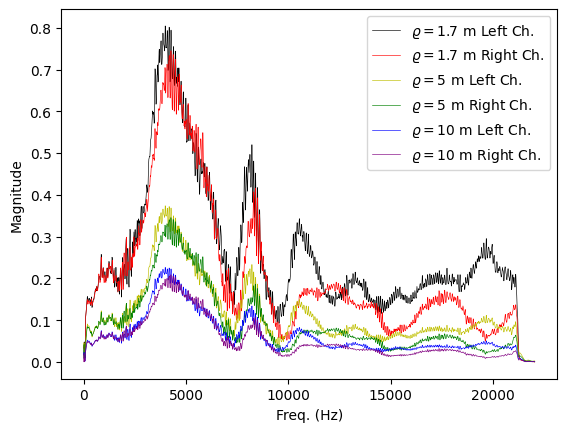

In [20]:
colors = ["k", "r", "y", "g", "b", "purple"]
freqs = np.fft.rfftfreq(n=hrirs[0].shape[0], d = 1 / 44100)
m1l = np.abs(np.fft.rfft(hrirs[0][:, 0]))
m1r = np.abs(np.fft.rfft(hrirs[0][:, 1]))
m2l = np.abs(np.fft.rfft(hrirs[1][:, 0]))
m2r = np.abs(np.fft.rfft(hrirs[1][:, 1]))
m3l = np.abs(np.fft.rfft(hrirs[2][:, 0]))
m3r = np.abs(np.fft.rfft(hrirs[2][:, 1]))
plt.plot(freqs, m1l, c=colors[0], lw=0.45, label=r'$\varrho =$' f'{distances[0]} m' ' Left Ch.')
plt.plot(freqs, m1r, c=colors[1], lw=0.45, label=r'$\varrho =$' f'{distances[0]} m' ' Right Ch.' )
plt.plot(freqs, m2l, c=colors[2], lw=0.45, label=r'$\varrho =$' f'{distances[1]} m' ' Left Ch.')
plt.plot(freqs, m2r, c=colors[3], lw=0.45, label=r'$\varrho =$' f'{distances[1]} m' ' Right Ch.')
plt.plot(freqs, m3l, c=colors[4], lw=0.45, label=r'$\varrho =$' f'{distances[2]} m' ' Left Ch.')
plt.plot(freqs, m3r, c=colors[5], lw=0.45, label=r'$\varrho =$' f'{distances[2]} m' ' Right Ch.')
plt.xlabel("Freq. (Hz)")
plt.ylabel("Magnitude")
plt.legend()
plt.show()

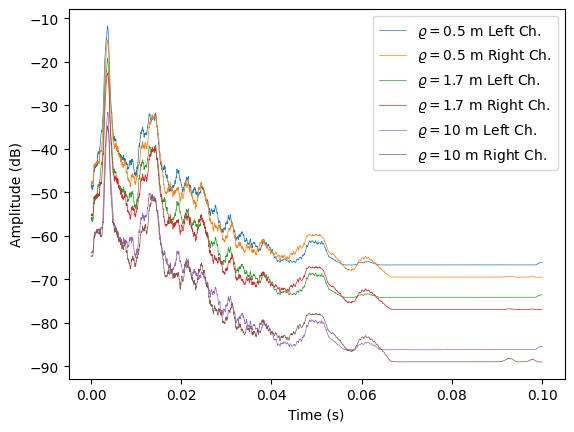

In [49]:
from scipy.ndimage import uniform_filter1d

# Finestra mobile su 5–15 campioni (dipende dalla Fs)
smooth = lambda x: uniform_filter1d(x, size=51)  # o 11, 15

t = np.arange(hrirs[0].shape[0]) / 44100

# HRIR in dB (tempo) → poi smooth
# m1l = smooth(np.abs(hrirs[0][:, 0]) * 9)
# m1r = smooth(np.abs(hrirs[0][:, 1]) * 9)
# m2l = smooth(np.abs(hrirs[1][:, 0]) * 9)
# m2r = smooth(np.abs(hrirs[1][:, 1]) * 9)
# m3l = smooth(np.abs(hrirs[4][:, 0]) * 9)
# m3r = smooth(np.abs(hrirs[4][:, 1]) * 9)
m1l = smooth(lb.amplitude_to_db(np.abs(hrirs[0][:, 0] * 9)))
m1r = smooth(lb.amplitude_to_db(np.abs(hrirs[0][:, 1] * 9)))
m2l = smooth(lb.amplitude_to_db(np.abs(hrirs[1][:, 0] * 9)))
m2r = smooth(lb.amplitude_to_db(np.abs(hrirs[1][:, 1] * 9)))
m3l = smooth(lb.amplitude_to_db(np.abs(hrirs[4][:, 0] * 9)))
m3r = smooth(lb.amplitude_to_db(np.abs(hrirs[4][:, 1] * 9)))
plt.plot(t, m1l, lw=0.5, label=r'$\varrho =$' f'{distances[0]} m' ' Left Ch.')
plt.plot(t, m1r, lw=0.5, label=r'$\varrho =$' f'{distances[0]} m' ' Right Ch.' )
plt.plot(t, m2l, lw=0.5, label=r'$\varrho =$' f'{distances[1]} m' ' Left Ch.')
plt.plot(t, m2r, lw=0.5, label=r'$\varrho =$' f'{distances[1]} m' ' Right Ch.')
plt.plot(t, m3l, lw=0.5, label=r'$\varrho =$' f'{distances[4]} m' ' Left Ch.')
plt.plot(t, m3r, lw=0.5, label=r'$\varrho =$' f'{distances[4]} m' ' Right Ch.')
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (dB)")
plt.legend()
plt.show()

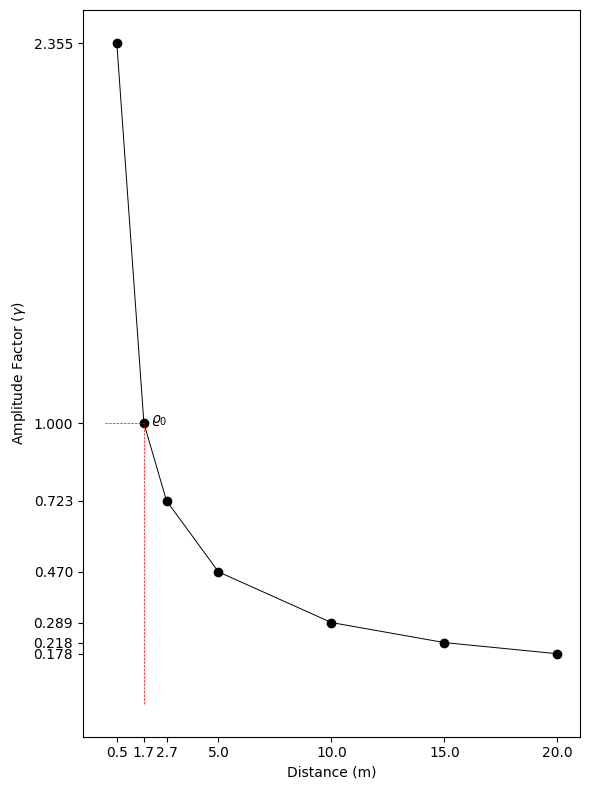

In [59]:
plt.figure(figsize=(6, 8))
att = np.array([2.35524039811009, 1.0, 0.7233685285168755, 0.4699322409041364, 0.28927722651989246, 0.21779623284513275, 0.17807102066893873])
# att = lb.amplitude_to_db(att)
plt.plot(distances, att, c="k", marker="o", lw=0.7)
plt.vlines(1.7, ymin=0.0, ymax=1.0, color="r", lw=0.5, linestyles="--")
plt.hlines(1.0, xmin=0.0, xmax=1.7, color="r", lw=0.5, linestyles="--")
plt.text(2.0, 1.0, r'$\varrho_0$')
plt.xticks(distances)
plt.yticks(att)
plt.xlabel("Distance (m)")
plt.ylabel(r"Amplitude Factor ($\gamma$)")
plt.tight_layout()
plt.show()

h183_BackPorchOfSuburbanHome_1txts h260_Classroom_1txts


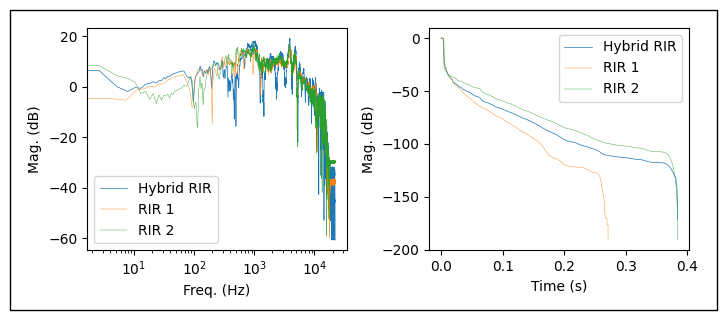

In [4]:
from matplotlib.patches import Rectangle


rir = kernels.rir
tx = np.arange(len(rir)) / SR
data = AURALIZER.get_rir_data(rir=rir)

r1 = AURALIZER.get_rir_key(rir_index=i1)
r2 = AURALIZER.get_rir_key(rir_index=i2)

r1d = AURALIZER.get_rir_data(rir=AURALIZER.get_rir(key=r1))
r2d = AURALIZER.get_rir_data(rir=AURALIZER.get_rir(key=r2))
tx1 = np.arange(len(r1d.rir)) / SR
tx2 = np.arange(len(r2d.rir)) / SR

print(r1, r2)

fig, ax = plt.subplots(1, 2, figsize=(7, 3))

ax[0].semilogx(data.freqs, lb.amplitude_to_db(data.power_spectrum), lw=0.5, label="Hybrid RIR")
ax[0].semilogx(r1d.freqs, lb.amplitude_to_db(r1d.power_spectrum), lw=0.3, label="RIR 1")
ax[0].semilogx(r2d.freqs, lb.amplitude_to_db(r2d.power_spectrum), lw=0.3, label="RIR 2")
ax[0].set_xlabel("Freq. (Hz)")
ax[0].set_ylabel("Mag. (dB)")
ax[0].legend()
ax[1].plot(tx, data.integr, lw=0.5, label="Hybrid RIR")
ax[1].plot(tx1, r1d.integr, lw=0.3, label="RIR 1")
ax[1].plot(tx2, r2d.integr, lw=0.3, label="RIR 2")
ax[1].set_xlabel("Time (s)")
ax[1].set_ylabel("Mag. (dB)")
ax[1].legend()

rect = Rectangle((-0.005, 0.01), 1.01, 1, transform=fig.transFigure, fill=False, color='black', linewidth=1)
fig.patches.append(rect)


plt.tight_layout()
plt.show()

In [10]:
AUDIO_PATH = "/Users/pm/AcaHub/AudioSamples/suzanne_mono.wav"
HRIR_PATH = "/Users/pm/AcaHub/Coding/BinauralSpatial/data/HRIR-KEMAR_DATASET.h5"
RIR_PATH = "/Users/pm/AcaHub/Coding/BinauralSpatial/data/RIR-MIT_SURVEY.h5"

SR = 44100
CHUNK = 2048
CHANNELS = 2

PARAMS = HybriParams(
        hrir_database_path=HRIR_PATH, 
        rir_database_path=RIR_PATH, 
        coord_mode=CoordMode.REGULAR, 
        interp_domain=InterpolationDomain.FREQUENCY,
        build_mode=BuildMode.SPHERICAL,
        chunk_size=CHUNK,
        interpolation_neighs=2
)

SIG, _ = lb.load(AUDIO_PATH, sr=SR)
SIG_LIMIT = len(SIG)


# start hybri
AURALIZER = Hybrizone(params=PARAMS)

# set air conditions
air_conditions = AirData(temperature=20, humidity=0.5, pressure=101325.0)
AURALIZER.imposed_air_conditions(air_data=air_conditions)

# pass the rirs
AURALIZER.set_rirs(rir1=np.random.randint(0, 100), rir2=np.random.randint(0, 190), smooth_factor=0.1)

audio = np.zeros((0, 2), dtype=np.float32)

current_phi = 0
current_theta = 0
current_rho = 0
run = True
mark = 0
curr_time = 0
back = False
dstep = 1
azis = [current_theta]
while True:
    
    if mark >= (SIG_LIMIT - CHUNK):

        # close hybri
        print(AURALIZER.get_proc_times())
        AURALIZER.close()
        run = False
        break
    
    end = min(mark + CHUNK, SIG_LIMIT - 1)
    frame = SIG[mark:end]
    
    # pass current position
    curr_ele = ((current_phi + 90) % 180)  - 90
    curr_azi = current_theta % 360
    
    if current_rho >= 100:
        back = True
    if current_rho <= 1:
        back = False
    
    if curr_time % 1 == 0:
        if back:
            current_rho -= dstep
        else:
            current_rho += dstep
            
    tstart = time.perf_counter()
    pos = PolarPoint(rho=1.7, phi=0.0, theta=curr_azi, opt=AngleMode.DEGREE) 
    AURALIZER.set_position(position=pos)
    
    if curr_time % 1 == 0:
        current_phi += 5
        current_theta += 5
        # print(curr_ele, curr_azi, curr_rho)
    
    # pass current hybrid space params
    AURALIZER.set_morph_data(direction=0.37, morph_curve=CurveMode.SIGMOID)

    # generates kernels (HRIR and RIR)
    kernels = AURALIZER.get_kernels()
    if kernels is not None:
        azis.append(curr_azi)
        # auralization
        convolved_frame = AURALIZER.process_frame(frame=frame, kernels=kernels)
        tend = time.perf_counter()
        # print(f"[INFO] Elapsed time: {tend - tstart}")
        audio = np.concatenate((audio, convolved_frame), axis=0)

        mark += CHUNK
        curr_time += 1


    # time.sleep(1 / SR)

{'htime': 0.000306884188179214, 'rtime': 0.0012390683110447612, 'ptime': 0.004463367937977511}
[INFO] Close Hybrizone...
[INFO] Free memory
[INFO] Hybrizone closed!


(987136, 2)


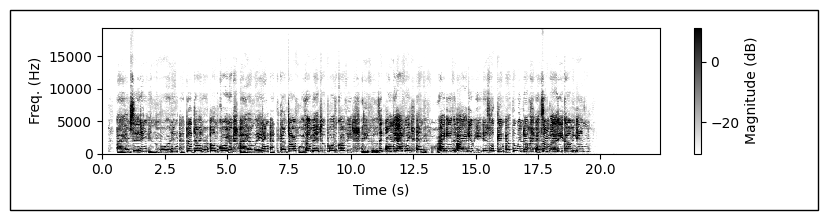

In [11]:
from matplotlib.patches import Rectangle

print(audio.shape)

left = audio[:, 0]
right = audio[:, 1]
lfft = lb.stft(left, n_fft=4096, hop_length=1024)
rfft = lb.stft(right, n_fft=4096, hop_length=1024)
magleft = lb.amplitude_to_db(np.abs(lfft))
magright = lb.amplitude_to_db(np.abs(rfft))


f = np.fft.rfftfreq(n=4096, d=1 / SR)
f[f <= 0] = 1e-6
t = np.arange(magleft.shape[1]) * (1024 / SR)

mag_total = (magleft + magright) / 2.0

fig, ax = plt.subplots(1, 1, figsize=(8, 2))

limit = 1800

# norml = Normalize(vmin=np.percentile(magleft, 3), vmax=np.percentile(magleft, 99))
# m1 = ax[0].pcolormesh(t[:], f[:limit], magleft[:limit, :], cmap="gray_r", shading="auto", label="Left Channel", norm=norml)
# ax[0].set_xlabel("Time (s)")
# ax[0].set_ylabel("Freq. (Hz)")
# ax[0].text(0.95, 0.95, "Left Channel", transform=ax[0].transAxes, fontsize=7, ha='right', va='top', color='white')
# normr = Normalize(vmin=np.percentile(magright, 3), vmax=np.percentile(magright, 99))
# m2 = ax[1].pcolormesh(t[:], f[:limit], magright[:limit, :], cmap="gray_r", shading="auto", label="Right Channel", norm=normr)
# ax[1].set_xlabel("Time (s)")
# ax[1].set_ylabel("Freq. (Hz)")
# ax[1].text(0.95, 0.95, "Right Channel", transform=ax[1].transAxes, fontsize=7, ha='right', va='top', color='white')
norm = Normalize(vmin=np.percentile(mag_total, 3), vmax=np.percentile(mag_total, 99))
m3 = ax.pcolormesh(t[:], f[:limit], mag_total[:limit, :], cmap="gray_r", shading="auto", label="Right Channel", norm=norm)
ax.set_xlabel("Time (s)")
ax.set_ylabel("Freq. (Hz)")
ax.text(0.95, 0.95, "Left + Right Channel", transform=ax.transAxes, fontsize=7, ha='right', va='top', color='white')

# fig.colorbar(m1, ax=ax[0], label="Magnitude (dB)")
# fig.colorbar(m2, ax=ax[1], label="Magnitude (dB)")
fig.colorbar(m3, ax=ax, label="Magnitude (dB)")

rect = Rectangle((-0.005, 0.01), 1.01, 1, transform=fig.transFigure, fill=False, color='black', linewidth=1)
fig.patches.append(rect)

plt.tight_layout()
plt.show()


In [18]:
2048 / 44100


0.046439909297052155

In [17]:
a1 = np.array(
    [
        [5.449678288012774e-05, 0.0004985064036729941, 0.008995278369217237], 
        [0.0019067424052061348, 0.0023065678713607984, 0.00816985214872413], 
        [0.00035295151458478554, 0.0012488519321205423, 0.007783576859379145], 
        [0.0018556779313169218, 0.0039848253975948225, 0.012634589174120275], 
        [0.0020784100982327762, 0.0006777974244257277, 0.006269549268373051]
    ]
)

b1 = np.mean(a1, axis=0)
b1


array([0.00124966, 0.00174331, 0.00877057])

In [3]:
10 * -10 ** (0 / 20)

-10.0

In [5]:
from hrir_builder import HrirHDFData

hdf = HrirHDFData(dataset_path="/Users/pm/AcaHub/Coding/BinauralSpatial/data/HRIR-KEMAR_DATASET.h5", coord_mode=CoordMode.REGULAR)
hdf.get_polar_reference(index=10), hdf.get_cartesian_reference(index=10), hdf.get_shape()

(array([116, -10], dtype=int16),
 array([ 0.88513935, -0.4317113 , -0.17364818]),
 array([4410,    2]))

In [6]:
freqs = np.fft.rfftfreq(4410, d=1 / 44100)
freqs[-1]

22050.0